## Age Classificaion/Analysis of Text and Age

Let's actually start with a classification model, gather the results, and then investigate.

Here's the plan for the upcoming work in the notebook --

- CountVectorizer (vector representation of text) on N-grams
- Train a Naive Bayes Classifier
- Look at most significant features
- Form hypotheses and iterate

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
data = pd.read_csv('../../data/blogtext 2.csv')
data.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [4]:
data['text'] = data['text'].str.strip()
data = data.drop(['id', 'gender', 'topic', 'sign', 'date'], axis = 1)
data['age_category'] = pd.cut(data['age'], bins=[10, 19, 29, 39], labels=['10s', '20s', '30s'])
data.head()


,age,text,age_category
0,15,"Info has been found (+/- 100 pages, and 4.5 MB...",10s
1,15,These are the team members: Drewes van der L...,10s
2,15,In het kader van kernfusie op aarde: MAAK JE ...,10s
3,15,testing!!! testing!!!,10s
4,33,Thanks to Yahoo!'s Toolbar I can now 'capture'...,30s


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


def train_classifier(texts, labels, ngrams):
    # create a CountVectorizer with character-based bigrams
    vectorizer = CountVectorizer(analyzer='char', ngram_range=ngrams, lowercase=False, stop_words=None)
    X = vectorizer.fit_transform(texts)
    # train the classifier and return it
    clf = MultinomialNB()
    clf.fit(X, labels)
    return clf, vectorizer

def train_word_classifier(texts, labels):
    # create a CountVectorizer with words
    vectorizer = CountVectorizer(lowercase=False, stop_words=None)
    X = vectorizer.fit_transform(texts)
    # train the classifier and return it
    clf = MultinomialNB()
    clf.fit(X, labels)
    return clf, vectorizer

def predict_age_group(classifier, vectorizer, new_text):
    # take in a classifier as input and return the prediction
    new_X = vectorizer.transform([new_text])
    predicted_age_group = classifier.predict(new_X)
    return predicted_age_group

def evaluate_classifier(classifier, vectorizer, test_texts, test_labels):
    # transform the test data
    X_test = vectorizer.transform(test_texts)
    # predict the age group and return score
    predicted_age_groups = classifier.predict(X_test)
    return accuracy_score(test_labels, predicted_age_groups)


def analyze_features(N, clf, vec):
    feature_names = list(vec.vocabulary_.keys())
    log_prob = clf.feature_log_prob_
    top_N_features = []
    for i in range(clf.classes_.shape[0]):
        top_N_indices = log_prob[i].argsort()[::-1][:N]
        top_N_features.extend([feature_names[idx] for idx in top_N_indices])
    print("Top {} most significant textual features:".format(N))
    print(top_N_features)


In [6]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(list(data['text']), list(data['age_category']), test_size=0.2)

Let's see if preprocessing matters. But first, let's get a bench mark.

In [8]:
# Train a classifier on the training data
clf, vectorizer = train_word_classifier(train_texts, train_labels)

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, test_texts, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)

analyze_features(10, clf, vectorizer)

Accuracy: 0.6355343211724902
Top 10 most significant textual features:
['concommitent', 'Porthcawl', 'Mazaa', 'Republispeak', 'غیرت', 'alcanza', 'tabindex', 'compañia', 'wangouette', 'Mathie', 'concommitent', 'Porthcawl', 'Mazaa', 'Republispeak', 'alcanza', 'wangouette', 'غیرت', 'Mathie', 'tabindex', 'Forgetaboutit', 'concommitent', 'Porthcawl', 'Mazaa', 'Republispeak', 'wangouette', 'alcanza', 'غیرت', 'Mathie', 'Forgetaboutit', 'tabindex', 'concommitent', 'Porthcawl', 'Mazaa', 'Republispeak', 'wangouette', 'alcanza', 'Mathie', 'غیرت', 'Forgetaboutit', 'Offee']


In [ ]:
# Train a classifier on the training data
clf, vectorizer = train_classifier(train_texts, train_labels, (2,2))

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, test_texts, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)
analyze_features(10, clf, vectorizer)

Accuracy: 0.4693116683913487
Top 10 most significant textual features:
[' 嘻', 'ce', '仲想', '同聲', ' g', '聲話', '但偏', '是向', '^6', "n'", ' 嘻', 'ce', '仲想', '同聲', ' g', '聲話', '但偏', '^6', '是向', "n'", ' 嘻', 'ce', '同聲', '仲想', ' g', '聲話', '但偏', '^6', '是向', ' Ａ', ' 嘻', 'ce', '同聲', ' g', '但偏', '仲想', '聲話', '^6', '是向', ' Ａ']


Okay, let's do some preprocessing to keep all english

In [ ]:
import re

def partial_preprocess_texts(texts):
    preprocessed_texts = []
    
    for text in texts:        
        # remove non-alphanumeric characters except for spaces
        text = re.sub(r'[^a-z\s]', '', text)
                
        # re-join the tokens into a single string
        preprocessed_text = text
        
        preprocessed_texts.append(preprocessed_text)
    
    return preprocessed_texts


In [ ]:
partial_preprocessed_train, partial_preprocessed_test = partial_preprocess_texts(train_texts), partial_preprocess_texts(test_texts)

In [ ]:
# Train a classifier on the training data
clf, vectorizer = train_classifier(partial_preprocessed_train, train_labels, (2,2))

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, partial_preprocessed_test, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)
analyze_features(10, clf, vectorizer)

Accuracy: 0.4713152351805779
Top 10 most significant textual features:
['lt', 'ex', 'lh', ' o', 'hx', 'vt', ' p', 'lk', 'ws', '\xa0n', 'lt', 'ex', 'lh', ' o', 'hx', 'vt', ' p', 'lk', 'ws', 'bl', 'lt', 'ex', ' o', 'lh', 'hx', 'vt', 'lk', ' p', 'ws', 'bl', 'lt', 'ex', 'hx', ' o', 'lh', 'vt', 'lk', ' p', 'ws', 'bl']


In [ ]:
import re

def preprocess_texts(texts):
    preprocessed_texts = []
    
    for text in texts:
        # lowercase the text
        text = text.lower()
        
        # remove URLs and email addresses
        text = re.sub(r'http\S+|www\S+|https\S+|ftp\S+|@\S+', '', text, flags=re.MULTILINE)
        
        # remove non-alphanumeric characters except for spaces
        text = re.sub(r'[^a-z\s]', '', text)
        
        # remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # re-join the tokens into a single string
        preprocessed_text = text
        
        preprocessed_texts.append(preprocessed_text)
    
    return preprocessed_texts


In [ ]:
preprocessed_train, preprocess_test = preprocess_texts(train_texts), preprocess_texts(test_texts)

In [ ]:
# Train a classifier on the training data
clf, vectorizer = train_word_classifier(preprocessed_train, train_labels)

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, preprocess_test, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)
analyze_features(10, clf, vectorizer)

Accuracy: 0.6380883183983208
Top 10 most significant textual features:
['waorcaaknvidutazhimtwy', 'pinangatawanan', 'responsiblity', 'squashesmelonszucchiniscucumbers', 'dotnessyness', 'wigglemunch', 'ppk', 'topicsquestions', 'modissa', 'blkdeth', 'waorcaaknvidutazhimtwy', 'pinangatawanan', 'responsiblity', 'squashesmelonszucchiniscucumbers', 'modissa', 'wigglemunch', 'dotnessyness', 'blkdeth', 'ppk', 'mittendorff', 'waorcaaknvidutazhimtwy', 'pinangatawanan', 'responsiblity', 'squashesmelonszucchiniscucumbers', 'modissa', 'wigglemunch', 'dotnessyness', 'blkdeth', 'mittendorff', 'ppk', 'waorcaaknvidutazhimtwy', 'pinangatawanan', 'responsiblity', 'squashesmelonszucchiniscucumbers', 'modissa', 'wigglemunch', 'blkdeth', 'dotnessyness', 'mittendorff', 'dazi']


In [ ]:
preprocessed_train[0:5]

['hello again this is the offical no action blog an extension of the no action column that can be found on urllink every month for anyone who stumbled in here i am anthony eldridge and no action is a monthly rock n roll column on thefootnotecom a monthly opinion webzine for those of you that came over from tfn i salute you the pupose of the blog is to get your opinions on the various subjects i write about the main concern of no action is how rock music fits into our culture not just my personal tastes therefore im going to be asking for your opinion on various matters which will help with the column you can also expect more inane ramblings on rock music and if youve followed me this far you must like that anyway keep checking in periodically and dont forget to read the footnote on the first of every month',
 'omg how the hell did i forget today is unofficial st pattys day green beer early bar openings damn allison i kno ure gonna be in murphys at is anyone else gonna be anywhere i hav

In [ ]:
# Train a classifier on the training data
clf, vectorizer = train_classifier(preprocessed_train, train_labels, (2,2))

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, preprocess_test, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)
analyze_features(10, clf, vectorizer)


Accuracy: 0.467880549256185
Top 10 most significant textual features:
['pu', 'of', 'vu', 'he', 'zr', 'vd', 'ai', 'oc', 'nn', 'eo', 'pu', 'of', 'vu', 'zr', 'he', 'vd', 'ai', 'nn', 'oc', 'eo', 'pu', 'of', 'vu', 'zr', 'vd', 'he', 'nn', 'ai', 'oc', 'eo', 'pu', 'of', 'zr', 'vd', 'he', 'vu', 'nn', 'oc', 'eo', 'ai']


In [ ]:
# Train a classifier on the training data
clf, vectorizer = train_word_classifier(preprocessed_train, train_labels)

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, preprocess_test, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)
analyze_features(10, clf, vectorizer)

Accuracy: 0.6405689248992712


finished preprocessing vs raw data. let's see what features were learned

How about feature engineering?

In [ ]:
"""
A bunch of helper functions for analysis of text, utilized by an effective main.
The plan is to use it for feature engineering / quantitative insights on code.
"""

import string

def count_double_spaces(text):
    """
    number of occurrences of double spaces in the given text (thanks Dr. Han!)
    """
    words = text.split()
    count = sum([1 for w in words if '  ' in w])
    return count

  
def count_punctuation(text):
    """
    number of punctuation marks in the given text.
    """
    return sum([1 for c in text if c in string.punctuation])


def calculate_punct_density(text):
    """
    punctuation density (# of punctuation / len of text)
    """
    total_chars = len(text)
    punct_count = count_punctuation(text)
    return 0 if total_chars == 0 else punct_count / total_chars


def count_exclamation_marks(text):
    """
    number of exclamation marks
    """
    return text.count('!')


def count_question_marks(text):
    """
    number of question marks
    """
    return text.count('?')


def calculate_exclamation_ratio(text):
    """
    ratio of exclamation marks to the total number of punctuation marks
    """
    punct_count = count_punctuation(text)
    exclamation_count = count_exclamation_marks(text)
    return 0 if punct_count == 0 else exclamation_count / punct_count


def calculate_question_ratio(text):
    """
    ratio of question marks to the total number of punctuation marks
    """
    punct_count = count_punctuation(text)
    question_count = count_question_marks(text)
    return 0 if punct_count == 0 else question_count / punct_count


def analyze(text):
    """
    returns everything
    """
    return {
        "punct_count": count_punctuation(text),
        "punct_density": calculate_punct_density(text),
        "exclamation_ratio": calculate_exclamation_ratio(text),
        "question_ratio": calculate_question_ratio(text),
        "double_spaces": count_double_spaces(text),
    }


In [ ]:
def extract_features(texts):
    """
    extract features from a list of texts using the analyze function
    """
    features = []
    for text in texts:
        analysis = analyze(text)
        features.append([
            analysis["punct_count"],
            analysis["punct_density"],
            analysis["exclamation_ratio"],
            analysis["question_ratio"],
            analysis["double_spaces"],
        ])
    return np.array(features)

def train_model(X_train, y_train):
    """
    trains a Multinomial Naive Bayes model on the training data
    """
    model = MultinomialNB()
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """
    evaluates the accuracy of the model on the testing data
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


# extract features from the training data
X_train = extract_features(preprocessed_train)
y_train = train_labels

# train the model
model = train_model(X_train, y_train)

# extract features from the testing data
X_test = extract_features(preprocess_test)
y_test = test_labels

# evaluate the model on the testing data
accuracy = evaluate_model(model, X_test, y_test)

# print the accuracy
print(f"Accuracy: {accuracy}")


Accuracy: 0.4711757928033055


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer

# create a pipeline that first extracts hand-crafted features,
# then vectorizes the texts using CountVectorizer, and finally applies
# feature selection using SelectKBest with chi2 and scaling using StandardScaler,
# before training a Multinomial Naive Bayes classifier
pipeline = Pipeline([
    ('extract_features', FeatureUnion([
        ('handcrafted', FunctionTransformer(extract_features)),
        ('vectorize', CountVectorizer()),
    ])),
    ('feature_selection', SelectKBest(chi2, k=1000)),
    ('scaling', StandardScaler(with_mean=False)),
    ('classification', MultinomialNB()),
])

# train the model
pipeline.fit(train_texts, train_labels)

# evaluate the model on the testing data
y_pred = pipeline.predict(test_texts)
accuracy = accuracy_score(test_labels, y_pred)

# print the accuracy
print(f"Accuracy: {accuracy}")

Accuracy: 0.557270452160256


Looks like it actually brings down the accuracy, looks like my feature engineering really doesn't help

Now, the next step is to form a way to test the feature engineering and the preprocessing, we can see if the BoW or the Character-level N-grams.

Let's work with the preprocessed text for now.

In [ ]:
# Train a classifier on the training data
clf, vectorizer = train_word_classifier(preprocessed_train, train_labels)

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, preprocess_test, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)
analyze_features(10, clf, vectorizer)

Accuracy: 0.6380883183983208
Top 10 most significant textual features:
['waorcaaknvidutazhimtwy', 'pinangatawanan', 'responsiblity', 'squashesmelonszucchiniscucumbers', 'dotnessyness', 'wigglemunch', 'ppk', 'topicsquestions', 'modissa', 'blkdeth', 'waorcaaknvidutazhimtwy', 'pinangatawanan', 'responsiblity', 'squashesmelonszucchiniscucumbers', 'modissa', 'wigglemunch', 'dotnessyness', 'blkdeth', 'ppk', 'mittendorff', 'waorcaaknvidutazhimtwy', 'pinangatawanan', 'responsiblity', 'squashesmelonszucchiniscucumbers', 'modissa', 'wigglemunch', 'dotnessyness', 'blkdeth', 'mittendorff', 'ppk', 'waorcaaknvidutazhimtwy', 'pinangatawanan', 'responsiblity', 'squashesmelonszucchiniscucumbers', 'modissa', 'wigglemunch', 'blkdeth', 'dotnessyness', 'mittendorff', 'dazi']


In [ ]:
# Train a classifier on the training data
clf, vectorizer = train_classifier(preprocessed_train, train_labels, (1,3))

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, preprocess_test, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)
analyze_features(10, clf, vectorizer)

Accuracy: 0.4563435273050192
Top 10 most significant textual features:
['h', 'nui', 'swy', 'w t', 'gdn', 'onz', 'nrd', 'oxp', 'cbs', 'yks', 'h', 'nui', 'swy', 'w t', 'gdn', 'onz', 'nrd', 'oxp', 'yks', 'cbs', 'h', 'nui', 'swy', 'w t', 'gdn', 'onz', 'nrd', 'oxp', 'yks', 'cbs', 'h', 'nui', 'swy', 'w t', 'gdn', 'onz', 'nrd', 'oxp', 'yks', 'cbs']


In [ ]:
# Train a classifier on the training data
clf, vectorizer = train_classifier(preprocessed_train, train_labels, (2,2))

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, preprocess_test, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)
analyze_features(10, clf, vectorizer)

Accuracy: 0.467880549256185
Top 10 most significant textual features:
['pu', 'of', 'vu', 'he', 'zr', 'vd', 'ai', 'oc', 'nn', 'eo', 'pu', 'of', 'vu', 'zr', 'he', 'vd', 'ai', 'nn', 'oc', 'eo', 'pu', 'of', 'vu', 'zr', 'vd', 'he', 'nn', 'ai', 'oc', 'eo', 'pu', 'of', 'zr', 'vd', 'he', 'vu', 'nn', 'oc', 'eo', 'ai']


In [ ]:
# Train a classifier on the training data
clf, vectorizer = train_classifier(preprocessed_train, train_labels, (3,3))

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, preprocess_test, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)
analyze_features(10, clf, vectorizer)

Accuracy: 0.47428755953822554
Top 10 most significant textual features:
['kno', 'jsy', 'lb ', ' tf', 'a b', 'juv', 'igk', 'tzd', 'is ', 'yan', 'kno', 'jsy', 'lb ', 'juv', 'tzd', 'a b', 'igk', 'is ', ' tf', 'oyv', 'kno', 'jsy', 'lb ', 'juv', 'tzd', 'a b', 'igk', 'is ', 'oyv', 'yan', 'kno', 'jsy', 'lb ', 'juv', 'a b', 'tzd', 'igk', 'is ', 'oyv', 'yan']


In [ ]:
# Train a classifier on the training data
clf, vectorizer = train_classifier(preprocessed_train, train_labels, (4,4))

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, preprocess_test, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)
analyze_features(10, clf, vectorizer)

Accuracy: 0.5128690636077412
Top 10 most significant textual features:
['ct o', 'agyn', 'kdnp', ' cyc', 's em', 't ju', 'diru', ' pun', 'p ta', 'buti', 'ct o', 'agyn', 'kdnp', 's em', ' cyc', 't ju', 'buti', 'diru', ' pun', 'fixj', 'ct o', 'agyn', 'kdnp', 's em', ' cyc', 't ju', 'buti', 'diru', ' pun', 'om h', 'ct o', 'agyn', 'kdnp', 's em', ' cyc', 't ju', 'buti', 'diru', 'om h', ' pun']


In [ ]:
# Train a classifier on the training data
clf, vectorizer = train_classifier(preprocessed_train, train_labels, (5,5))

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, preprocess_test, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)
analyze_features(10, clf, vectorizer)

Accuracy: 0.5582759050911146
Top 10 most significant textual features:
['at tc', 'ntere', 'b was', 's wfi', 'quiks', 'ehair', 'lay p', 'tly a', 'ayape', 'ubiqu', 'at tc', 'ntere', 'b was', 's wfi', 'lay p', 'quiks', 'ehair', 'nkisr', 'ayape', 'w das', 'at tc', 'ntere', 'b was', 's wfi', 'lay p', 'nkisr', 'ehair', 'iwine', 'ayape', 'quiks', 'at tc', 'ntere', 'b was', 's wfi', 'nkisr', 'lay p', 'ehair', 'iwine', 'w das', 'ayape']


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

def train_word_classifier_tfidf(texts, labels):
    # create a TfidfVectorizer with words
    vectorizer = TfidfVectorizer(lowercase=False, stop_words=None)
    X = vectorizer.fit_transform(texts)
    # train the classifier and return it
    clf = MultinomialNB()
    clf.fit(X, labels)
    return clf, vectorizer


In [ ]:
# Train a classifier on the training data
clf, vectorizer = train_word_classifier_tfidf(preprocessed_train, train_labels)

# Evaluate the classifier on the test data
accuracy = evaluate_classifier(clf, vectorizer, preprocess_test, test_labels)

# Print the accuracy score
print("Accuracy:", accuracy)
analyze_features(10, clf, vectorizer)

Accuracy: 0.5869643394467807
Top 10 most significant textual features:
['waorcaaknvidutazhimtwy', 'pinangatawanan', 'responsiblity', 'topicsquestions', 'ppk', 'dotnessyness', 'squashesmelonszucchiniscucumbers', 'wigglemunch', 'blkdeth', 'dazi', 'waorcaaknvidutazhimtwy', 'pinangatawanan', 'responsiblity', 'squashesmelonszucchiniscucumbers', 'wigglemunch', 'modissa', 'routerenable', 'ppk', 'dotnessyness', 'blkdeth', 'waorcaaknvidutazhimtwy', 'pinangatawanan', 'responsiblity', 'squashesmelonszucchiniscucumbers', 'routerenable', 'modissa', 'wigglemunch', 'dotnessyness', 'blkdeth', 'ppk', 'waorcaaknvidutazhimtwy', 'pinangatawanan', 'responsiblity', 'squashesmelonszucchiniscucumbers', 'routerenable', 'modissa', 'wigglemunch', 'blkdeth', 'dotnessyness', 'mittendorff']


In [5]:
import pandas as pd 
# Load the dataset
data = pd.read_csv('../../../data/blogtext 2.csv')
data.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [7]:
data['text'] = data['text'].str.strip()
data = data.drop(['id', 'gender', 'topic', 'sign', 'date'], axis = 1)
data['age_category'] = pd.cut(data['age'], bins=[10, 19, 29, 39], labels=['10s', '20s', '30s'])
data.head()

,age,text,age_category
0,15,"Info has been found (+/- 100 pages, and 4.5 MB...",10s
1,15,These are the team members: Drewes van der L...,10s
2,15,In het kader van kernfusie op aarde: MAAK JE ...,10s
3,15,testing!!! testing!!!,10s
4,33,Thanks to Yahoo!'s Toolbar I can now 'capture'...,30s


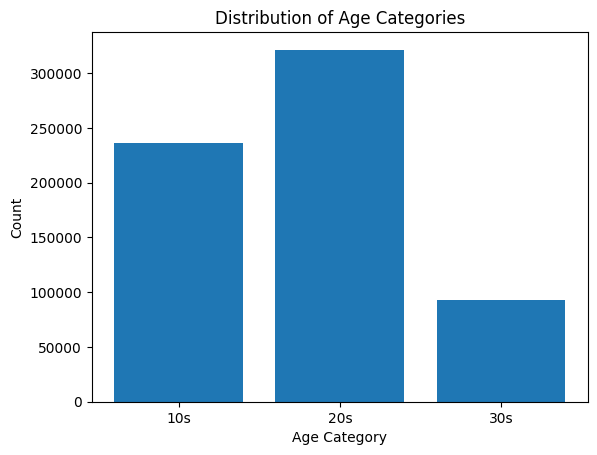

In [8]:
import matplotlib.pyplot as plt

# Group the data by age category and count the number of occurrences
counts = data.groupby('age_category').size()

# Create a bar chart of the counts by age category
plt.bar(counts.index, counts.values)

# Set the axis labels and chart title
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.title('Distribution of Age Categories')

# Show the chart
plt.savefig('../../../images/blog_distribution.png')

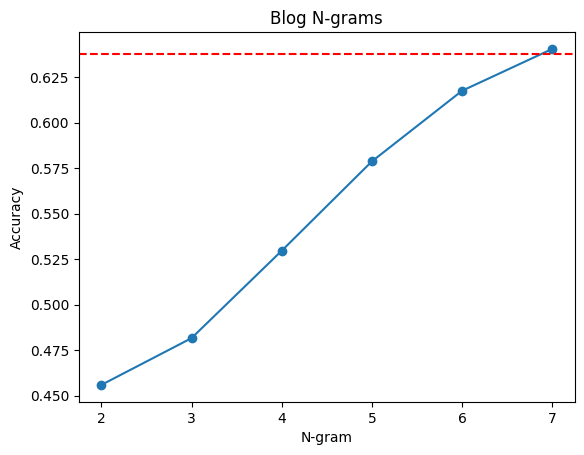

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data points as tuples
data = [
    ((2,2), 0.4559),
    ((3,3), 0.4816),
    ((4,4), 0.5296),
    ((5,5), 0.5787),
    ((6,6), 0.6175),
    ((7,7), 0.6405)
    
]

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['coordinates', 'values'])

# Set the coordinates column as the index and split into separate columns
df[['x', 'y']] = pd.DataFrame(df['coordinates'].tolist(), index=df.index)

# Create a line plot of the values by x coordinate
plt.plot(df['x'], df['values'], marker='o')

# Add a horizontal line at y=0.6405
plt.axhline(y=0.6376, color='red', linestyle='--')

# Set the axis labels and chart title
plt.xlabel('N-gram')
plt.ylabel('Accuracy')
plt.title('Blog N-grams')

# Show the chart
plt.savefig('../../../images/blog_n_grams.png')